In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

Defining an ODE that does SIR population Dynamics and the capital growth equation in a single ODE (Andrew code)

In [2]:
def population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3):
    #TODO: incorporate Michael's capital effectiveness that changes with age
    #TODO: make it so that n incorporates arbitrary ages for entering/leaving the labor force
    # Validate input parameters
    if not isinstance(life_expectancy, int):
        raise ValueError("Life expectancy must be an integer in this model")
    elif life_expectancy < 40:
        raise ValueError("This model requires life_expectancy to be at least 40")

    def ode(t, x):
        """
        Ordinary differential equation representing the SIR population dynamics with granular fertility
        AND the capital growth model.
        Incorporates a population schock at time t=50 where 10% of the 18-40 population die

        Parameters:
        - t: Time variable.
        - x: Array representing the state variables, where x[i] represents the number of people at age i.
        x[:-1] = population of each age group
        x[-1] = capital k

        Returns:
        - dx: Array representing the rates of change of the state variables.
        dx[:-1] = change in population of each age group
        dx[-1] =  k' (change of capital)
        """
        dx = np.zeros_like(x)

        # Calculate the births based on the fertility rate
        if callable(fertility_rate):
            dx[0] = 0.5 * fertility_rate(t) * np.mean(x[fertility_starts:fertility_ends + 1])-x[0]
        else:
            dx[0] = 0.5 * fertility_rate * np.mean(x[fertility_starts:fertility_ends + 1]) - x[0]

        # Calculate the change in other age categories
        dx[1:-1] = x[:-2] - x[1:-1]
        # dx[1:] = x[:-1] - x[1:]
        
        #Calculate current working population rate change
        n = (dx[18] - dx[66])/np.sum(x[18:66])

        #Define a function to return the income per person in the economy. 
        def y(k, alpha=alpha, A=A):
            if callable(A):
                return A(t)*k**alpha
            else:
                return A*k**alpha

        #The captital evolution equation
        def kprime(k, alpha=alpha, s=s, delta=delta, n=n, A=A):
            return s*y(k, alpha, A) - (delta + n)*k
        
        #Define the last element of dx to be capital growth
        dx[-1] = kprime(x[-1], alpha=alpha, s=s, delta=delta, n=n, A=A)

        return dx
    return ode

Consolidate Age Groups Function (Andrew Code)

In [3]:
def consolidate_age_groups(x,age_brackets = [18,40,65],return_labels = False):
    age_brackets.sort()
    M = [0]+age_brackets + [len(x)]
    ns = np.array([np.sum(x[M[i]:M[i+1]],axis = 0)for i in range(len(M)-1)])
    if return_labels:
        labels = [f"{M[i]}-{M[i+1]}" for i in range(len(M)-1)]
        return ns,labels
    else:
        return ns

### Simulating the effect on a war on a country's economy:
We will now modify the granular population model to have a shock in which 10% of all 18-40 year olds die in a war, 10% of the country's capital is lost in the war
We then use the following equations:
$$\dot n_0 = \frac {1} {2} r_f \sum_{i = 20}^{40} \frac{n_i}{20}$$
$$\dot n_i = n_{i-1} - n_i, \ \forall i \in \{1,2,...,k\}$$
Where $r_f$ is the fertility rate and $k$ is the 'life expectancy'.


In [4]:
def population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3):
    # Validate input parameters
    if not isinstance(life_expectancy, int):
        raise ValueError("Life expectancy must be an integer in this model")
    elif life_expectancy < 40:
        raise ValueError("This model requires life_expectancy to be at least 40")

    def ode(t, x):
        """
        Ordinary differential equation representing the SIR population dynamics with granular fertility
        AND the capital growth model.
        Incorporates a population schock at time t=50 where 10% of the 18-40 population die

        Parameters:
        - t: Time variable.
        - x: Array representing the state variables, where x[i] represents the number of people at age i.
        x[:-1] = population of each age group
        x[-1] = capital k

        Returns:
        - dx: Array representing the rates of change of the state variables.
        dx[:-1] = change in population of each age group
        dx[-1] =  k' (change of capital)
        """
        dx = np.zeros_like(x)

        # Calculate the births based on the fertility rate
        if callable(fertility_rate):
            dx[0] = 0.5 * fertility_rate(t) * np.mean(x[fertility_starts:fertility_ends + 1])-x[0]
        else:
            dx[0] = 0.5 * fertility_rate * np.mean(x[fertility_starts:fertility_ends + 1]) - x[0]

        # Calculate the change in other age categories
        dx[1:-1] = x[:-2] - x[1:-1]
        # dx[1:] = x[:-1] - x[1:]
        
        #Calculate current working population rate change
        n = (dx[18] - dx[66])/np.sum(x[18:66])

        #Define a function to return the income per person in the economy. 
        def y(k, alpha=alpha, A=A):
            if callable(A):
                return A(t)*k**alpha
            else:
                return A*k**alpha

        #The captital evolution equation
        def kprime(k, alpha=alpha, s=s, delta=delta, n=n, A=A):
            return s*y(k, alpha, A) - (delta + n)*k
        
        dx[-1] = kprime(x[-1], alpha=alpha, s=s, delta=delta, n=n, A=A)

        return dx
    return ode



Define the same function but now with the modification:
$$\dot n_* = -.1n$$
$$\dot k_* = -.1k$$
$$\text{At }t_* = \text{time of shock}$$

In [5]:
def population_with_captial_growth_shocks(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3):
    #TODO: incorporate Michael's capital effectiveness that changes with age
    #TODO: make it so that n incorporates arbitrary ages for entering/leaving the labor force
    # Validate input parameters
    if not isinstance(life_expectancy, int):
        raise ValueError("Life expectancy must be an integer in this model")
    elif life_expectancy < 40:
        raise ValueError("This model requires life_expectancy to be at least 40")

    def ode(t, x):
        """
        Ordinary differential equation representing the SIR population dynamics with granular fertility
        AND the capital growth model.
        Incorporates a population schock at time t=50 where 10% of the 18-40 population die

        Parameters:
        - t: Time variable.
        - x: Array representing the state variables, where x[i] represents the number of people at age i.
        x[:-1] = population of each age group
        x[-1] = capital k

        Returns:
        - dx: Array representing the rates of change of the state variables.
        dx[:-1] = change in population of each age group
        dx[-1] =  k' (change of capital)
        """
        dx = np.zeros_like(x)

        # Calculate the births based on the fertility rate
        if callable(fertility_rate):
            dx[0] = 0.5 * fertility_rate(t) * np.mean(x[fertility_starts:fertility_ends + 1])-x[0]
        else:
            dx[0] = 0.5 * fertility_rate * np.mean(x[fertility_starts:fertility_ends + 1]) - x[0]

        # Calculate the change in other age categories
        dx[1:-1] = x[:-2] - x[1:-1]
        
        #Calculate current working population rate change
        n = (dx[18] - dx[66])/np.sum(x[18:66])

        #Define a function to return the income per person in the economy. 
        def y(k, alpha=alpha, A=A):
            if callable(A):
                return A(t)*k**alpha
            else:
                return A*k**alpha


        #The captital evolution equation
        def kprime(k, alpha=alpha, s=s, delta=delta, n=n, A=A):
            return s*y(k, alpha, A) - (delta + n)*k
        
        dx[-1] = kprime(x[-1], alpha=alpha, s=s, delta=delta, n=n, A=A)

        #Model the population & capital shock at time t=50:
        if 49.5<= t and t <=50.5:
            dx[18:40] = -.1*x[18:40]
            dx[-1] = -.1*x[-1]



        return dx
    return ode

Modeling

/tmp/ipykernel_11808/2322237867.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return A*k**alpha


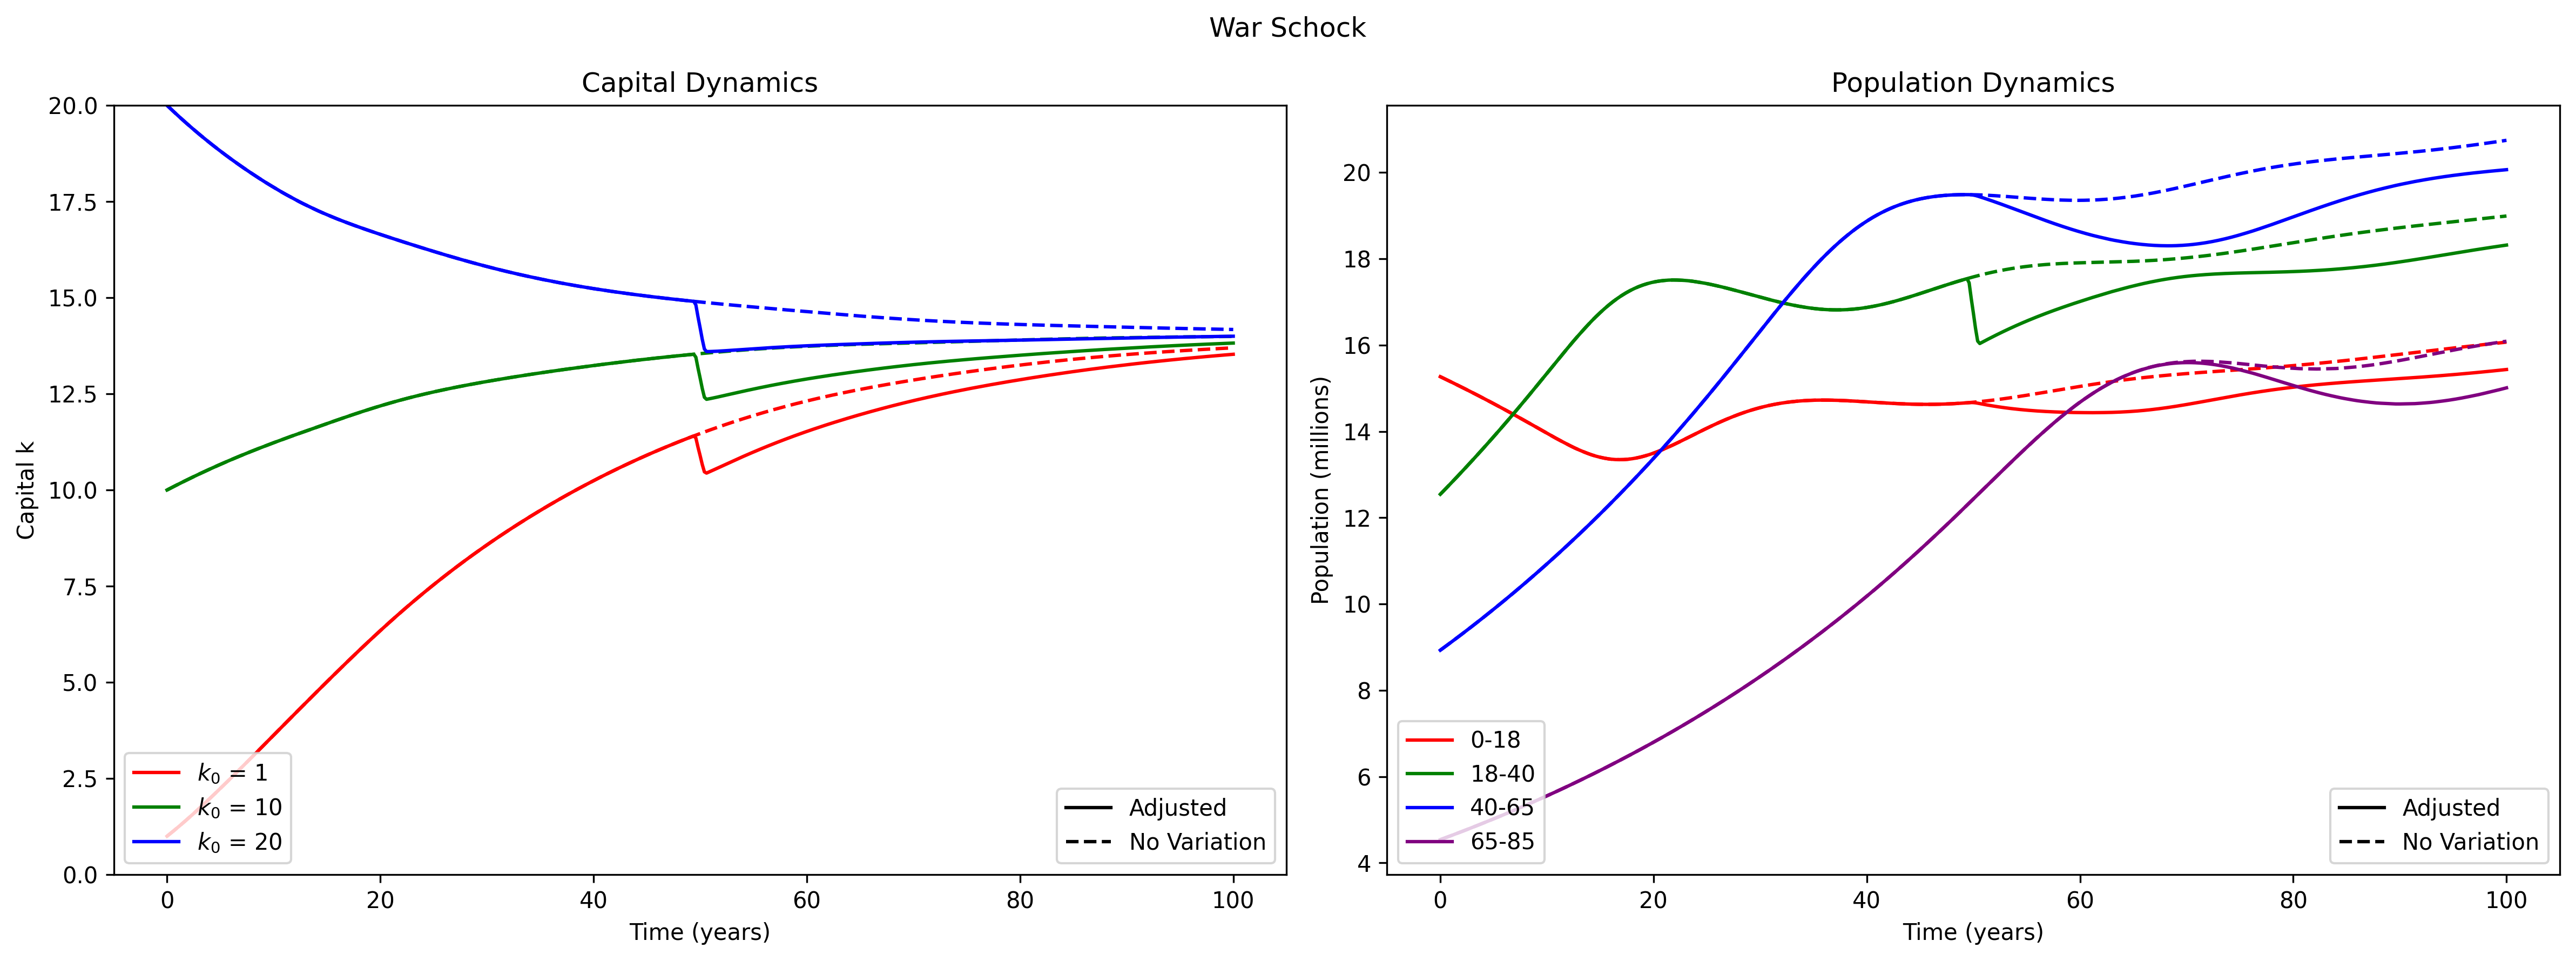

In [13]:
#Define several k initial conditions, plotting conditions
IC = [1,10,20]
count = 0
plt.figure(figsize=(16,6),dpi=300)
plt.subplot(121)
label_list = ["Adjusted", "No Variation"]
colors = ["red", "green", "blue"]#,"orange","purple"]
line_style = ["--", "-"]
color_legend = []
style_legend = []

#Iterate through initial conditions, plot both the shock and the growth without shock
for k in IC:
    # Here we initialize the ode function to solve for the shock situation
    ode_shock = population_with_captial_growth_shocks(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3)
    ode_normal = population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3)
    ts = np.linspace(0,100,501)
    # Here we set the initial conditions
    life_expect = 85
    pop_0 = np.exp(-.02*np.arange(life_expect))
    k0 = [k]
    x0 = np.concatenate((pop_0,k0))

    sol_shock = solve_ivp(ode_shock,(0,100),x0,t_eval=ts)
    sol_normal = solve_ivp(ode_normal,(0,100),x0,t_eval=ts)

    # Here consolidate the ages into age brackets, to make the data more visible
    # Grouping the age brackets will also make it easier for our model
    pop_values_shock,pop_labels = consolidate_age_groups(sol_shock.y[:-1],return_labels=True)
    pop_values_normal,pop_labels = consolidate_age_groups(sol_normal.y[:-1],return_labels=True)

    #Plot capital
    color = colors[count]
    plt.plot(sol_shock.t,sol_shock.y[-1],'-',color = color)
    plt.plot(sol_normal.t,sol_normal.y[-1],'--',color = color)

    #Add color line to legend
    colorLine = Line2D([0,1],[0,1], linestyle='-', color=color)
    color_legend.append(colorLine)
    count = count + 1

#Make 2 legends, set other plot information
styleLine = Line2D([0,1],[0,1], linestyle='-', color="black")    
style_legend.append(styleLine)
styleLine = Line2D([0,1],[0,1], linestyle='--', color="black")    
style_legend.append(styleLine)
legend1 = plt.legend(color_legend, [r"$k_0$" + " = " + str(k0) for k0 in IC], loc=3)
plt.legend(style_legend, label_list, loc=4)
plt.gca().add_artist(legend1)

plt.xlabel("Time (years)")
plt.ylabel("Capital k")
plt.suptitle(f"War Schock")
plt.title('Capital Dynamics')
plt.ylim([0,20])
plt.tight_layout()

# Here we plot the population growth
label_list = ["Adjusted", "No Variation"]
colors = ["red", "green", "blue","purple"]
color_legend = []
style_legend = []
plt.subplot(122)
for i in range(pop_values_shock.T.shape[1]):
    color = colors[i]
    to_plot_shock = pop_values_shock.T[:,i]
    to_plot_normal = pop_values_normal.T[:,i]
    plt.plot(sol_shock.t,to_plot_shock,'-',color = color)
    plt.plot(sol_normal.t,to_plot_normal,'--',color = color)
    #Add color line to legend
    colorLine = Line2D([0,1],[0,1], linestyle='-', color=color)
    color_legend.append(colorLine)
#Make 2 legends, set other plot information
styleLine = Line2D([0,1],[0,1], linestyle='-', color="black")    
style_legend.append(styleLine)
styleLine = Line2D([0,1],[0,1], linestyle='--', color="black")    
style_legend.append(styleLine)
legend1 = plt.legend(color_legend, pop_labels, loc=3)
plt.legend(style_legend, label_list, loc=4)
plt.gca().add_artist(legend1)

plt.xlabel("Time (years)")
plt.ylabel("Population (millions)")
plt.title("Population Dynamics")
plt.tight_layout()
plt.show()

Government makes huge investment in technology

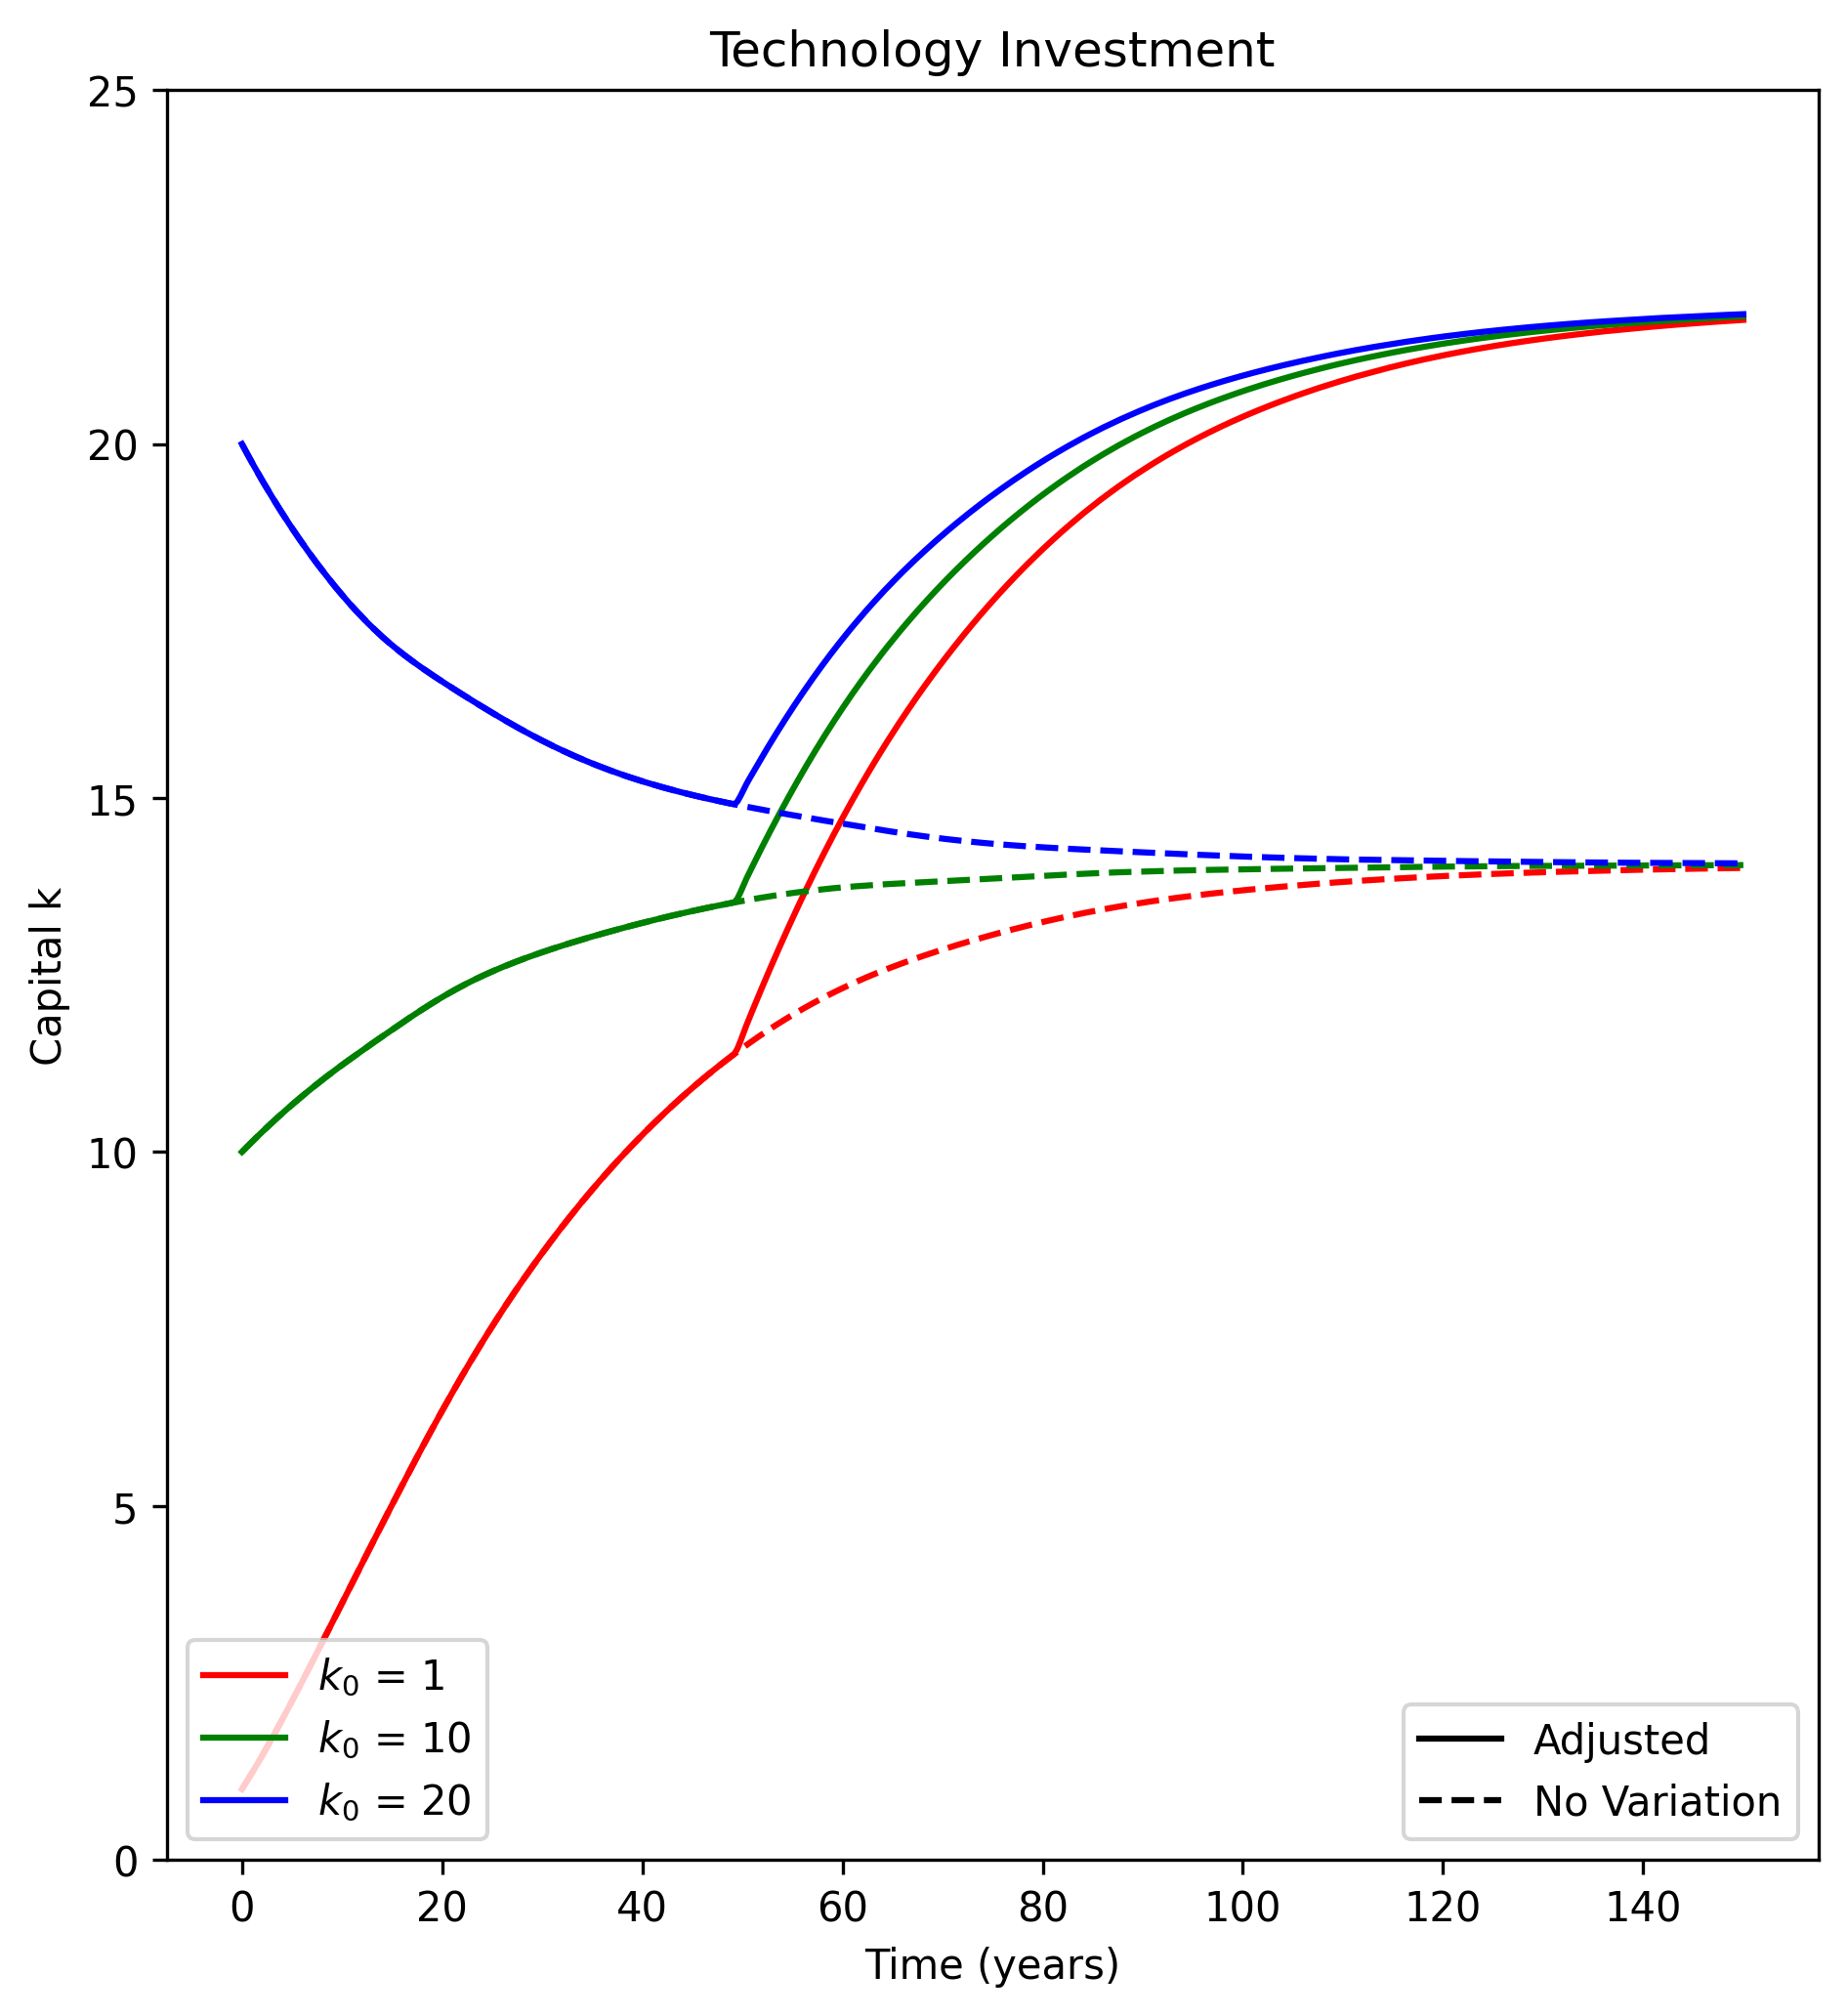

In [9]:
#Define an investment shock function
def A_investment(t):
    if 49.5 <= t:
        return 1.25
    else:
        return 1
IC = [1,10,20]
ts = np.linspace(0,150,501)
plt.figure(figsize=(16,8),dpi=300)
plt.subplot(121)
label_list = ["Adjusted", "No Variation"]
colors = ["red", "green", "blue"]#,"orange","purple"]
line_style = ["--", "-"]
color_legend = []
style_legend = []

for i in range(len(IC)):
    k = IC[i]
    #Define initial conditions
    x0 = np.concatenate((pop_0,[k]))
    
    #Define and solve technology shock and normal ODEs
    ode_tech = population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=A_investment,alpha=.5,delta=0.08,s=.3)
    sol_tech = solve_ivp(ode_tech,(0,150),x0,t_eval=ts)

    ode_normal = population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3)
    sol_normal = solve_ivp(ode_normal,(0,150),x0,t_eval=ts)

    #Plot Capital
    color = colors[i]
    plt.plot(sol_tech.t,sol_tech.y[-1],'-',color = color)
    plt.plot(sol_normal.t,sol_normal.y[-1],'--',color = color)
    #Append legend info
    colorLine = Line2D([0,1],[0,1], linestyle='-', color=color)
    color_legend.append(colorLine)
#Make 2 legends, set other plot information
styleLine = Line2D([0,1],[0,1], linestyle='-', color="black")    
style_legend.append(styleLine)
styleLine = Line2D([0,1],[0,1], linestyle='--', color="black")    
style_legend.append(styleLine)
legend1 = plt.legend(color_legend, [r"$k_0$" + " = " + str(k0) for k0 in IC], loc=3)
plt.legend(style_legend, label_list, loc=4)
plt.gca().add_artist(legend1)

    
plt.xlabel("Time (years)")
plt.ylabel("Capital k")
plt.title(f'Technology Investment')
plt.ylim([0,25])
plt.show()